In [27]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import h5py
import seaborn as sea

In [13]:
DATASET = '/Users/stepanmazokha/Desktop/lora_rffi_dataset/Train/dataset_training_no_aug.h5'

In [14]:
def convert_to_complex(data):
    '''Convert the loaded data to complex IQ samples.'''
    num_row = data.shape[0]
    num_col = data.shape[1] 
    data_complex = np.zeros([num_row,round(num_col/2)],dtype=complex)

    data_complex = data[:,:round(num_col/2)] + 1j*data[:,round(num_col/2):] 
    return data_complex
    
def load_iq_samples(file_path, dev_range, pkt_range):
    f = h5py.File(file_path,'r')
    label = f['label'][:]
    label = label.astype(int)
    label = np.transpose(label)
    label = label - 1
    
    label_start = int(label[0]) + 1
    label_end = int(label[-1]) + 1
    num_dev = label_end - label_start + 1
    num_pkt = len(label)
    num_pkt_per_dev = int(num_pkt/num_dev)
    
    print('Dataset information: Dev ' + str(label_start) + ' to Dev ' + 
            str(label_end) + ', ' + str(num_pkt_per_dev) + ' packets per device.')
    
    sample_index_list = []
    
    for dev_idx in dev_range:
        sample_index_dev = np.where(label==dev_idx)[0][pkt_range].tolist()
        sample_index_list.extend(sample_index_dev)

    data = f['data'][sample_index_list]
    data = convert_to_complex(data)
    
    label = label[sample_index_list]
        
    f.close()
    return data,label

In [34]:
class ChannelIndSpectrogram():
    def __init__(self,):
        pass
    
    def _normalization(self,data):
        ''' Normalize the signal.'''
        s_norm = np.zeros(data.shape, dtype=complex)
        
        for i in range(data.shape[0]):
        
            sig_amplitude = np.abs(data[i])
            rms = np.sqrt(np.mean(sig_amplitude**2))
            s_norm[i] = data[i]/rms
        
        return s_norm        

    def _spec_crop(self, x):
        '''Crop the generated channel independent spectrogram.'''
        num_row = x.shape[0]
        x_cropped = x[round(num_row*0.3):round(num_row*0.7)]
    
        return x_cropped


    def _gen_single_channel_ind_spectrogram(self, sig, win_len=256, overlap=128):
        '''
        _gen_single_channel_ind_spectrogram converts the IQ samples to a channel
        independent spectrogram according to set window and overlap length.
        
        INPUT:
            SIG is the complex IQ samples.
            
            WIN_LEN is the window length used in STFT.
            
            OVERLAP is the overlap length used in STFT.
            
        RETURN:
            
            CHAN_IND_SPEC_AMP is the genereated channel independent spectrogram.
        '''

        print(sig.shape)
        # Short-time Fourier transform (STFT).
        f, t, spec = signal.stft(sig, 
                                window='boxcar', 
                                nperseg= win_len, 
                                noverlap= overlap, 
                                nfft= win_len,
                                return_onesided=False, 
                                padded = False, 
                                boundary = None)
        
        # FFT shift to adjust the central frequency.
        spec = np.fft.fftshift(spec, axes=0)

        print(spec.shape)
        
        # Generate channel independent spectrogram.
        chan_ind_spec = spec[:,1:]/spec[:,:-1]   

        print(chan_ind_spec.shape) 
        
        # Take the logarithm of the magnitude.      
        chan_ind_spec_amp = np.log10(np.abs(chan_ind_spec)**2)
                  
        return chan_ind_spec_amp
    


    def channel_ind_spectrogram(self, data):
        '''
        channel_ind_spectrogram converts IQ samples to channel independent 
        spectrograms.
        
        INPUT:
            DATA is the IQ samples.
            
        RETURN:
            DATA_CHANNEL_IND_SPEC is channel independent spectrograms.
        '''
        
        # Normalize the IQ samples.
        data = self._normalization(data)
        
        # Calculate the size of channel independent spectrograms.
        num_sample = data.shape[0]
        num_row = int(256*0.4)
        num_column = int(np.floor((data.shape[1]-256)/128 + 1) - 1)
        data_channel_ind_spec = np.zeros([num_sample, num_row, num_column, 1])
        
        # Convert each packet (IQ samples) to a channel independent spectrogram.
        for i in range(num_sample):
                   
            chan_ind_spec_amp = self._gen_single_channel_ind_spectrogram(data[i])
            chan_ind_spec_amp = self._spec_crop(chan_ind_spec_amp)
            data_channel_ind_spec[i,:,:,0] = chan_ind_spec_amp
            
        return data_channel_ind_spec


In [35]:
# Data shape: (15000, 8192)
# - 15000 = 500 packets * 30 devices (# of packets)
# - 8192 samples (# of samples per packet)
data, label = load_iq_samples(file_path = DATASET, 
                              dev_range = np.arange(0,30, dtype = int), 
                              pkt_range = np.arange(0,500, dtype = int))

ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
# Convert time-domain IQ samples to channel-independent spectrograms.
data_spectrogram = ChannelIndSpectrogramObj.channel_ind_spectrogram(data)

/var/folders/3q/s65kgr2x141dhd8vlqbvz7800000gn/T/ipykernel_82307/1663685570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_start = int(label[0]) + 1
/var/folders/3q/s65kgr2x141dhd8vlqbvz7800000gn/T/ipykernel_82307/1663685570.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_end = int(label[-1]) + 1


Dataset information: Dev 1 to Dev 30, 500 packets per device.
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 63)
(256, 62)
(8192,)
(256, 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


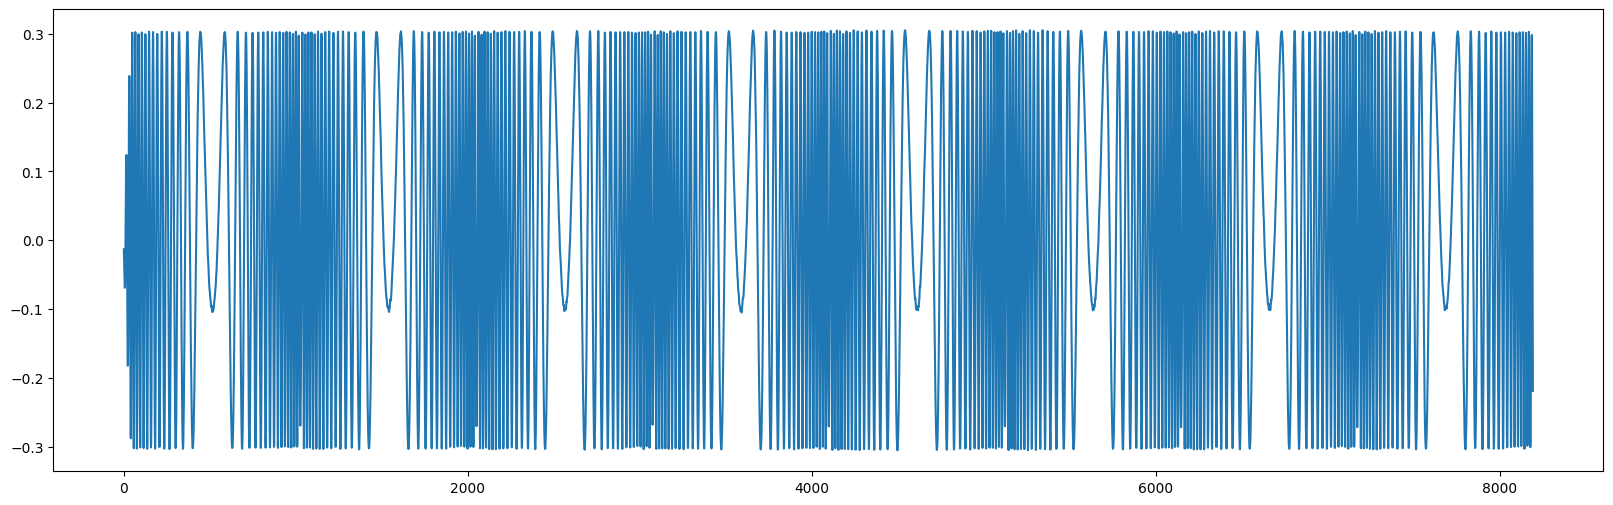

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(8192), data[1400, :])

(102, 62)


<Axes: >

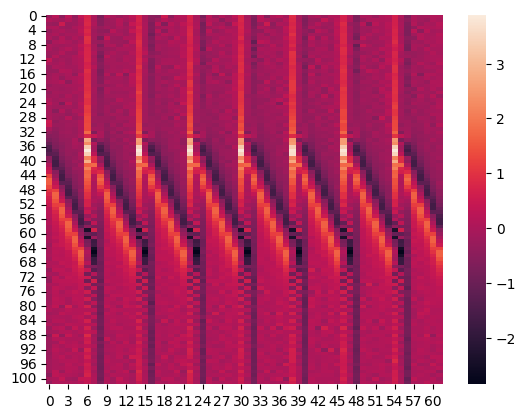

In [29]:
pic = data_spectrogram[0, :, :, 0]

print(pic.shape)
sea.heatmap(pic)